In [1]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

In [2]:
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')

image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']

for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    image_mode = image.mode
    if image_mode != 'RGB':
        image = np.asarray(image)
        os.remove(image_path)

image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']

class_list = set()
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    class_list.add(class_name)
class_list = list(class_list)

class_list.sort()

class2idx = {cls:idx for idx, cls in enumerate(class_list)}

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

image_files.sort()

In [3]:
cnt = 0
previous_class = ""
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    if class_name == previous_class:
        cnt += 1
    else:
        cnt = 1
    if cnt <= 160:
        cpath = train_dir
    else:
        cpath = val_dir
    image_path = os.path.join(image_dir, image_file)
    shutil.copy(image_path, cpath)
    previous_class = class_name

In [4]:
train_images = os.listdir(train_dir)
val_images = os.listdir(val_dir)

# TFRecord File 만들기

In [5]:
IMG_SIZE = 224

tfr_dir = os.path.join(data_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'cls_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'cls_val.tfr')

writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [6]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [7]:
n_train = 0

train_files = os.listdir(train_dir)
for train_file in train_files:
    train_path = os.path.join(train_dir, train_file)
    image = Image.open(train_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()
    
    file_name = os.path.splitext(train_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    class_num = class2idx[class_name]
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'cls_num': _int64_feature(class_num)
    }))
    writer_train.write(example.SerializeToString())
    n_train += 1

writer_train.close()



n_val = 0

val_files = os.listdir(val_dir)
for val_file in val_files:
    val_path = os.path.join(val_dir, val_file)
    image = Image.open(val_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()
    
    file_name = os.path.splitext(val_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    class_num = class2idx[class_name]
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'cls_num': _int64_feature(class_num)
    }))
    writer_val.write(example.SerializeToString())
    n_val += 1

writer_val.close()

# Classification

In [32]:
## Hyper Parameters
N_CLASS = len(class_list)
N_EPOCHS = 50
N_BATCH = 10
N_TRAIN = n_train
N_VAL = n_val
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [33]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32) / 255. 

    label = tf.cast(parsed_features['cls_num'], tf.int64)
    label = tf.one_hot(label, N_CLASS)
    
    return image, label

In [34]:
## CutMix
def cutmix(images, labels, PROB=0.5):
    imgs = []; labs = []
    for i in range(N_BATCH):
        APPLY = tf.cast(tf.random.uniform(()) <= PROB, tf.int32)
        idx = tf.random.uniform((), 0, N_BATCH, tf.int32)
        
        W = IMG_SIZE; H = IMG_SIZE
        lam = tf.random.uniform(())
        cut_ratio = tf.math.sqrt(1.-lam)
        cut_w = tf.cast(W * cut_ratio, tf.int32) * APPLY
        cut_h = tf.cast(H * cut_ratio, tf.int32) * APPLY
        
        cx = tf.random.uniform((), int(W/8), int(7/8*W), tf.int32)
        cy = tf.random.uniform((), int(H/8), int(7/8*H), tf.int32)
        
        xmin = tf.clip_by_value(cx - cut_w//2, 0, W)
        ymin = tf.clip_by_value(cy - cut_h//2, 0, H)
        xmax = tf.clip_by_value(cx + cut_w//2, 0, W)
        ymax = tf.clip_by_value(cy + cut_h//2, 0, H)
        
        mid_left = images[i, ymin:ymax, :xmin, :]
        mid_mid = images[idx, ymin:ymax, xmin:xmax, :]
        mid_right = images[i, ymin:ymax, xmax:, :]
        middle = tf.concat([mid_left, mid_mid, mid_right], axis=1)
        top = images[i, :ymin, :, :]
        bottom = images[i, ymax:, :, :]
        new_img = tf.concat([top, middle, bottom], axis=0)
        imgs.append(new_img)
        
        alpha = tf.cast((cut_w*cut_h)/(W*H), tf.float32)
        label1 = labels[i]; label2 = labels[idx]
        new_label = ((1-alpha)*label1 + alpha*label2)
        labs.append(new_label)
        
    new_imgs = tf.reshape(tf.stack(imgs), [-1, IMG_SIZE, IMG_SIZE, 3])
    new_labs = tf.reshape(tf.stack(labs), [-1, N_CLASS])
    
    return new_imgs, new_labs

In [35]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH)
train_dataset = train_dataset.map(cutmix).repeat()

In [36]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


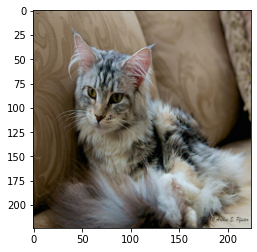

[0.         0.         0.         0.         0.34707826 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.65292174 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


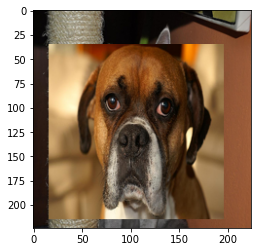

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.88729674 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.11270326 0.
 0.         0.         0.         0.         0.         0.
 0.        ]


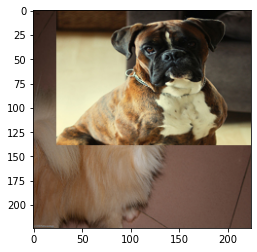

[0.         0.         0.         0.         0.         0.
 0.29663584 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.70336413
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


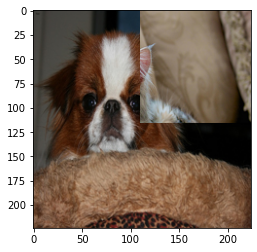

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


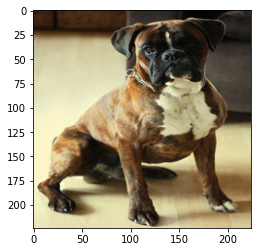

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


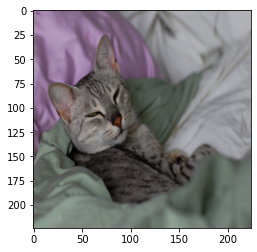

[0.         0.         0.         0.         0.21556123 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.7844388
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


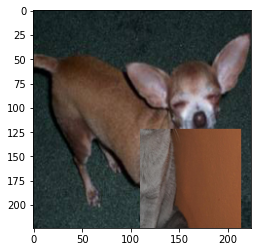

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


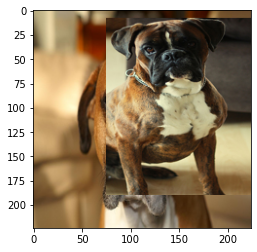

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.44842157
 0.         0.         0.         0.         0.         0.
 0.         0.5515784  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


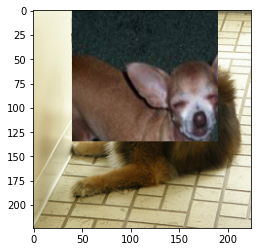

[0.        0.        0.        0.        0.        0.6747449 0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.3252551 0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.       ]


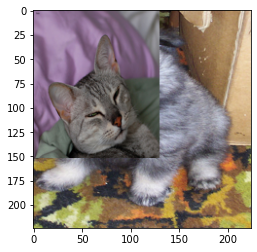

In [37]:
for image, label in train_dataset.take(1):
    for i in range(N_BATCH):
        print(label[i].numpy())
        plt.imshow(image[i])
        plt.show()

In [34]:
from tensorflow.keras import models
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [35]:
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [36]:
def create_mv_model():
    model = models.Sequential()
    model.add(mobilenetv2)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(N_CLASS, activation='softmax'))
    return model

In [37]:
## Create model, compile & summary
model = create_mv_model()

LR_INIT = 0.000001
LR_MAX = 0.0002
LR_MIN = LR_INIT
RAMPUP_EPOCH = 4
EXP_DECAY = 0.9

def lr_schedule_fn(epoch):
    if epoch < RAMPUP_EPOCH:
        lr = (LR_MAX - LR_MIN) / RAMPUP_EPOCH * epoch + LR_INIT
    else:
        lr = (LR_MAX - LR_MIN) * EXP_DECAY**(epoch - RAMPUP_EPOCH)
    return lr

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule_fn)

model.compile(optimizer=tf.keras.optimizers.Adam(LR_INIT),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 256)               0         
                                                      

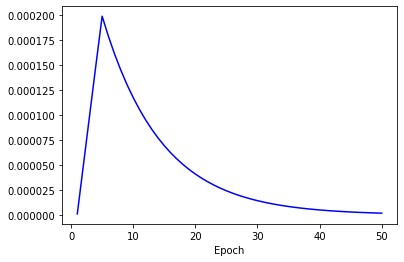

In [38]:
def plot_lr():
    lr = []
    epoch_list = list(np.arange(N_EPOCHS) + 1)
    for epoch in range(N_EPOCHS):
        lr.append(lr_schedule_fn(epoch))
    plt.plot(epoch_list, lr, 'b-')
    plt.xlabel('Epoch')
    plt.show()
    
plot_lr()

In [39]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[lr_callback]
)

Epoch 1/50
296/296 [==============================] - 71s 217ms/step - loss: 4.0311 - accuracy: 0.0235 - val_loss: 4.0069 - val_accuracy: 0.0240 - lr: 1.0000e-06
Epoch 2/50
296/296 [==============================] - 65s 216ms/step - loss: 2.5505 - accuracy: 0.4520 - val_loss: 1.1731 - val_accuracy: 0.8436 - lr: 5.0750e-05
Epoch 3/50
296/296 [==============================] - 66s 218ms/step - loss: 1.8314 - accuracy: 0.6921 - val_loss: 1.0955 - val_accuracy: 0.8759 - lr: 1.0050e-04
Epoch 4/50
296/296 [==============================] - 66s 218ms/step - loss: 1.6713 - accuracy: 0.7529 - val_loss: 1.0983 - val_accuracy: 0.8697 - lr: 1.5025e-04
Epoch 5/50
296/296 [==============================] - 66s 218ms/step - loss: 1.6149 - accuracy: 0.7632 - val_loss: 1.1881 - val_accuracy: 0.8477 - lr: 1.9900e-04
Epoch 6/50
296/296 [==============================] - 65s 216ms/step - loss: 1.5294 - accuracy: 0.8041 - val_loss: 1.1656 - val_accuracy: 0.8491 - lr: 1.7910e-04
Epoch 7/50
296/296 [========

In [38]:
from tensorflow.keras.applications.densenet import DenseNet121

In [39]:
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [40]:
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
densenet.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                       

 conv2_block4_0_relu (Activatio  (None, 56, 56, 160)  0          ['conv2_block4_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_blo

 conv3_block10_concat (Concaten  (None, 28, 28, 448)  0          ['conv3_block9_concat[0][0]',    
 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
          

                                                                                                  
 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block7_0_relu (Activatio  (None, 14, 14, 448)  0          ['conv4_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)

 ate)                                                             'conv4_block15_2_conv[0][0]']   
                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_rel

 ization)                                                                                         
                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_blo

 conv5_block8_concat (Concatena  (None, 7, 7, 768)   0           ['conv5_block7_concat[0][0]',    
 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
          

 on)                                                                                              
                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

In [41]:
def create_dense_model():
    model = models.Sequential()
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(N_CLASS, activation='softmax'))
    return model

In [42]:
## Create model, compile & summary
model = create_dense_model()

LR_INIT = 0.000001
LR_MAX = 0.0002
LR_MIN = LR_INIT
RAMPUP_EPOCH = 4
EXP_DECAY = 0.9

def lr_schedule_fn(epoch):
    if epoch < RAMPUP_EPOCH:
        lr = (LR_MAX - LR_MIN) / RAMPUP_EPOCH * epoch + LR_INIT
    else:
        lr = (LR_MAX - LR_MIN) * EXP_DECAY**(epoch - RAMPUP_EPOCH)
    return lr

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule_fn)

model.compile(optimizer=tf.keras.optimizers.Adam(LR_INIT),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 37)               

In [43]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[lr_callback]
)

Epoch 1/50
592/592 [==============================] - 163s 254ms/step - loss: 3.9083 - accuracy: 0.0434 - val_loss: 3.8230 - val_accuracy: 0.0610 - lr: 1.0000e-06
Epoch 2/50
592/592 [==============================] - 152s 254ms/step - loss: 2.4304 - accuracy: 0.4976 - val_loss: 1.0946 - val_accuracy: 0.8855 - lr: 5.0750e-05
Epoch 3/50
592/592 [==============================] - 153s 254ms/step - loss: 1.8042 - accuracy: 0.7041 - val_loss: 1.0859 - val_accuracy: 0.8909 - lr: 1.0050e-04
Epoch 4/50
592/592 [==============================] - 153s 254ms/step - loss: 1.7367 - accuracy: 0.7270 - val_loss: 1.1952 - val_accuracy: 0.8484 - lr: 1.5025e-04
Epoch 5/50
592/592 [==============================] - 158s 262ms/step - loss: 1.6935 - accuracy: 0.7412 - val_loss: 1.2786 - val_accuracy: 0.8162 - lr: 1.9900e-04
Epoch 6/50
592/592 [==============================] - 157s 262ms/step - loss: 1.6145 - accuracy: 0.7655 - val_loss: 1.1027 - val_accuracy: 0.8807 - lr: 1.7910e-04
Epoch 7/50
592/592 [==

# 새로운 Image로 Test하기

In [47]:
## Image upload 후 실행
image = Image.open('chihuahua.jpg')
image = image.resize((224, 224))
image = np.array(image)
image = image/255.

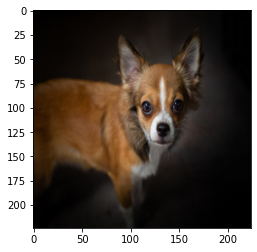

In [48]:
plt.imshow(image)
plt.show()

In [49]:
image = np.reshape(image, (1, 224, 224, 3))

In [50]:
prediction = model.predict(image)
prediction.shape

1/1 [==============================] - 5s 5s/step


(1, 37)

In [51]:
pred_class = np.argmax(prediction, axis=-1)
pred_class

array([17], dtype=int64)

In [52]:
class_list[int(pred_class)]

'chihuahua'

In [53]:
image2 = Image.open('persian.jpg')
image2 = image2.resize((224, 224))
image2 = np.array(image2)
image2 = image2/255.

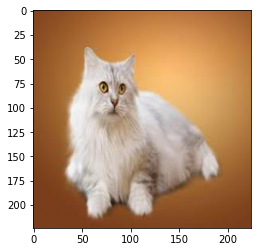

In [54]:
plt.imshow(image2)
plt.show()

In [55]:
image2 = np.reshape(image2, (1, 224, 224, 3))

In [56]:
prediction = model.predict(image2)
prediction.shape

1/1 [==============================] - 0s 50ms/step


(1, 37)

In [57]:
pred_class = np.argmax(prediction, axis=-1)
pred_class

array([7], dtype=int64)

In [58]:
class_list[int(pred_class)]

'Persian'